## This is a hotmap visualizer for the explain result of a single ionic molecule pair

In [ ]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt
from Dataset_explain import IL_set
from Model import IL_Net_GCN,GIN,IL_GAT
from Explainer import IL_Explainer
from GIN_Runner import Args
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# global args
idx = 10

In [3]:
# load model
model = GIN(Args)
state_dict_mod = torch.load('best_model_para.pth',map_location=torch.device('cpu'))
model.load_state_dict(state_dict_mod)

# get data
Whole_set = IL_set(path = Args['data_path'])
explain_loader = DataLoader(Whole_set,batch_size = 1,shuffle=False,collate_fn=IL_set.collate_fn)
for i,(graph,cond,label,num_bond) in enumerate(explain_loader):
    if i == idx:
        break

----info----
data_length 10116
------------


/home/ftyuejian/miniconda3/envs/IL/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
# explain
explainer = IL_Explainer(model, epochs = 150,lr = 0.001,return_type='log_prob')
node_feat_mask, edge_mask = explainer.explain_graph(graph,cond)
# process and show the shape of the mask
node_mask = edge_mask[num_bond:]

In [5]:
# process node weight
num_node = graph.x.shape[0] - 1
w_n = []
for i in range(num_node):
    w = (node_mask[i] + node_mask[i + num_node])/2
    w_n.append(w.item())

In [6]:
# build networkx graph
Gr,c,l,num_b = Whole_set[idx]
g = nx.Graph()
# add node
node_list = list(range(Gr.x.shape[0] - 1))
g.add_nodes_from(node_list)

# add edge
node_a = ((Gr.edge_index)[0][0:num_b]).tolist()
node_b = ((Gr.edge_index)[1][0:num_b]).tolist()

edge = []
for item in zip(node_a,node_b):
    edge.append(item)
g.add_edges_from(edge)

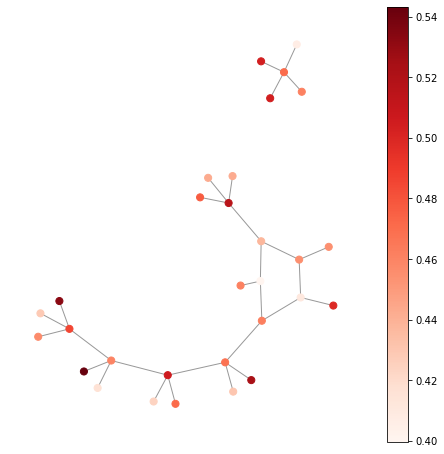

In [7]:
pos = nx.spring_layout(g, seed=400) 

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(g, pos, alpha=0.4)
node = nx.draw_networkx_nodes(
    g,
    pos,
    nodelist=list(g.nodes),
    node_size=50,
    node_color=w_n,
    cmap=plt.cm.Reds,
)

plt.colorbar(node)
plt.axis("off")
plt.savefig('importance hot map for single IL')